In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

/tmp/ipykernel_395/2377440119.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv", \
                    header=0, usecols=['age', 'bmi', 'children', 'charges'])
data

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


In [3]:
# Standardize Predictors
data['bmi'] = (data['bmi'] - data['bmi'].mean()) / data['bmi'].std()
data['age'] = (data['age'] - data['age'].mean()) / data['age'].std()
data['children'] = (data['children'] - data['children'].mean()) / data['children'].std()
data['charges'] = (data['charges'] - data['charges'].mean()) / data['charges'].std()
data


,age,bmi,children,charges
0,-1.438227,-0.453151,-0.908274,0.298472
1,-1.509401,0.509431,-0.078738,-0.953333
2,-0.797655,0.383164,1.580335,-0.728402
3,-0.441782,-1.305043,-0.908274,0.719574
4,-0.512957,-0.292447,-0.908274,-0.776512
...,...,...,...,...
1333,0.768185,0.050278,1.580335,-0.220468
1334,-1.509401,0.206062,-0.908274,-0.913661
1335,-1.509401,1.014499,-0.908274,-0.961237
1336,-1.295877,-0.797515,-0.908274,-0.930014


In [4]:
# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [5]:
# Prepare data for Stan
N_train = len(train_data)
x_train = np.column_stack((train_data['bmi'], train_data['age'], train_data['children']))
y_train = train_data['charges'].to_numpy()
K = x_train.shape[1]

######################################
N_test = len(test_data)
x_test = np.column_stack((test_data['bmi'], test_data['age'], test_data['children']))
y_test = test_data['charges'].to_numpy()
K = x_test.shape[1]

In [6]:
stan_data = {
    'N': N_train,
    'K': K,
    'x': x_train,
    'y': y_train,
    'N_test': N_test,
    'x_test': x_test,
    'y_test':y_test,
    'tau_0': 1,
    'tau_1': 1,
    'sigma_alpha': 5,
    'sigma_beta': np.array([5, 5, 5])
}

In [7]:
vectorized_program_code = """
data {
    int<lower=0> N;         
    int<lower=1> K;
    matrix[N, K] x;
    vector[N] y;

    int<lower=0> N_test;         
    matrix[N_test, K] x_test;
    vector[N_test] y_test;
    
    real<lower=0> tau_0; 
    real<lower=0> tau_1; 
    real<lower=0> sigma_alpha; 
    vector<lower=0>[K] sigma_beta;        
}

parameters {
    real alpha; 
    vector[K] beta; 
    real<lower=0> sigma2; 
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    target += inv_gamma_lpdf(sigma2 | tau_0, tau_1);
    target += normal_lpdf(alpha | 0, sigma_alpha);
    target += multi_normal_lpdf(beta | rep_vector(0, K), diag_matrix(sigma_beta));
    
    // Likelihood
    target += normal_lpdf(y | alpha + x*beta, sigma);
}

generated quantities{
  array[N_test] real preds = normal_rng(alpha + x_test*beta, sigma);
}
"""

In [8]:
vectorized_posterior = stan.build(vectorized_program_code, data=stan_data, random_seed=42)

fit_vectorized = vectorized_posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%


Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000209 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000214 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.14 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_1rh94e_5/model_um2bv6rt.stan', line 36, column 4 to column 53)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-co

In [9]:
summary = az.summary(fit_vectorized)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.029,-0.046,0.061,0.000,0.000,9398.0,5977.0,1.0
beta[0],0.167,0.029,0.113,0.222,0.000,0.000,9612.0,5901.0,1.0
beta[1],0.256,0.029,0.200,0.309,0.000,0.000,9192.0,5848.0,1.0
beta[2],0.056,0.028,0.001,0.107,0.000,0.000,10234.0,6345.0,1.0
sigma2,0.881,0.039,0.805,0.951,0.000,0.000,8775.0,6095.0,1.0
...,...,...,...,...,...,...,...,...,...
preds[263],0.505,0.942,-1.146,2.386,0.010,0.007,8091.0,8014.0,1.0
preds[264],0.200,0.922,-1.475,1.978,0.011,0.007,7704.0,7546.0,1.0
preds[265],-0.117,0.937,-1.820,1.658,0.010,0.007,7981.0,8012.0,1.0
preds[266],0.670,0.941,-1.175,2.401,0.011,0.008,7571.0,7909.0,1.0


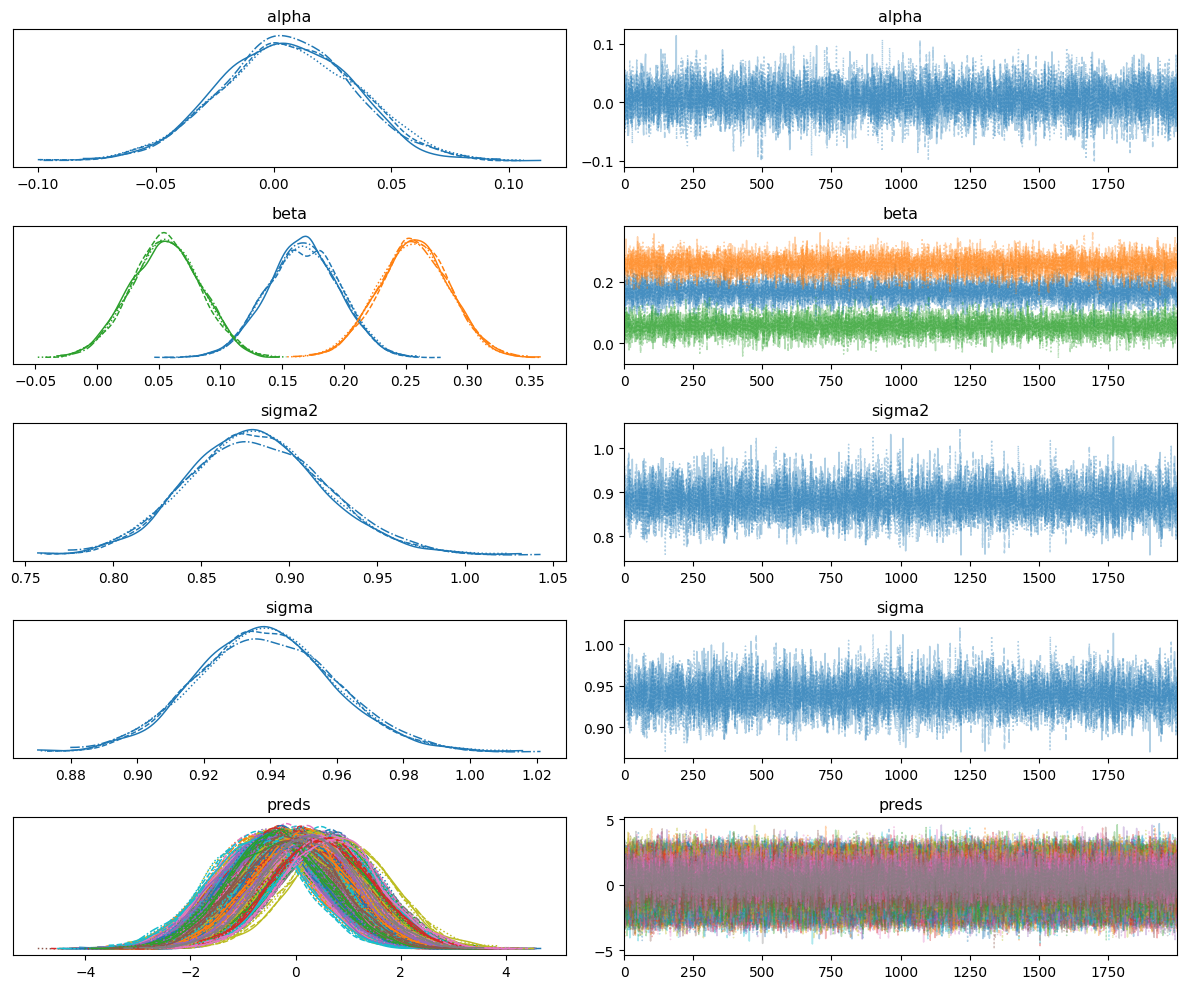

In [10]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit_vectorized)
plt.tight_layout()

In [11]:
# Calculate RMSE 
preds = fit_vectorized.__getitem__('preds')
preds_mean = preds.mean(axis=1) 
RMSE = np.sqrt(np.mean((preds_mean - y_test)**2))
RMSE

0.9451566666911531

#### How good are your predictions? 
The RMSE value provides the deviation between predicted and actual values. Lower values of RMSE indicate better predictive performance. Our RMSE value, 0.945, is very high which mean our model wasn't able to predict these values very accurately.

#### What information did you lose by computing the predictive means? 
By computing predictive means we collapse our dataset into one value. This means we lose information about uncertainty. By the look of our graphs, there is quite a bit of uncertainty in predictive values. By losing this information, our prediction did a poor job of representing the underlying data generating process

#### How could you possibly propagate the uncertainty information encoded in the predictive distribution to obtain a distribution over the test RMSE values?
We would want to use a method that take mulitple samples of the predictive distribution and compute the RMSE value for each individual sample. This would give us a distribution of RMSE value that allow us to understand the uncertainty in our original distributions.
